## Vikas Chaudhary
### MDS202353

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from datasets import Dataset

In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define file paths
train_path = '/content/drive/My Drive/AML_Assignment_5/train.csv'
test_path = '/content/drive/My Drive/AML_Assignment_5/test.csv'

df_train = pd.read_csv(train_path, encoding="latin1")
df_test = pd.read_csv(test_path,encoding="latin1")

Mounted at /content/drive


In [5]:
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [6]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [9]:
df_train.shape, df_test.shape

((27481, 10), (4815, 9))

In [10]:
# KEEPING RELAVANT COLUMNS
train_data = pd.DataFrame(df_train[['text', 'sentiment']])

test_data = pd.DataFrame(df_test[['text', 'sentiment']])

In [11]:
test_data.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


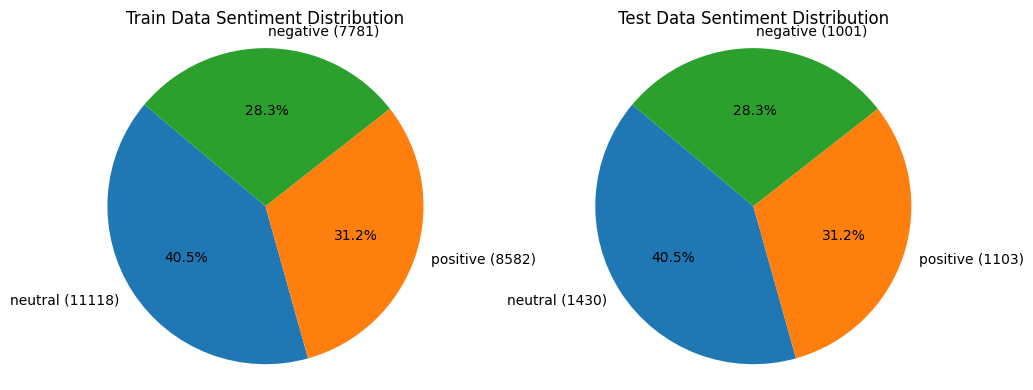

In [12]:
def plot_sentiment_pie(train_data, test_data):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Train data
    train_counts = train_data['sentiment'].value_counts()
    axes[0].pie(
        train_counts,
        labels=[f"{label} ({count})" for label, count in zip(train_counts.index, train_counts)],
        autopct='%1.1f%%',
        startangle=140
    )
    axes[0].set_title("Train Data Sentiment Distribution")
    axes[0].axis('equal')

    # Test data
    test_counts = test_data['sentiment'].value_counts()
    axes[1].pie(
        test_counts,
        labels=[f"{label} ({count})" for label, count in zip(test_counts.index, test_counts)],
        autopct='%1.1f%%',
        startangle=140
    )
    axes[1].set_title("Test Data Sentiment Distribution")
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()

# Call the function
plot_sentiment_pie(train_data, test_data)

In [13]:
# Clearing Missing/NaN values
def check_and_clean_missing_values(df):
    print("Missing Values Count:")
    missing_counts = df.isnull().sum()
    print(missing_counts[missing_counts > 0])  # Show only columns with missing values

    initial_shape = df.shape
    df_cleaned = df.dropna()
    final_shape = df_cleaned.shape

    print(f"\nRemoved {initial_shape[0] - final_shape[0]} rows with missing values.")
    print(f"New shape of dataset: {final_shape}")

    return df_cleaned

train_data = check_and_clean_missing_values(train_data)
print("\n")
print("------------------------------------------------")
print("\n")
test_data = check_and_clean_missing_values(test_data)

Missing Values Count:
text    1
dtype: int64

Removed 1 rows with missing values.
New shape of dataset: (27480, 2)


------------------------------------------------


Missing Values Count:
text         1281
sentiment    1281
dtype: int64

Removed 1281 rows with missing values.
New shape of dataset: (3534, 2)


In [14]:
# Basic Preprocessing
def preprocess_text(text):
    return text.strip()

train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [15]:
# 1. Map the Labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['sentiment'])
test_data['label'] = le.transform(test_data['sentiment'])


In [16]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# 2. Load tokenizer and model (3 output classes: positive, neutral, negative)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [18]:
# 3. Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_data[['text', 'label']])
test_dataset = Dataset.from_pandas(test_data[['text', 'label']])

In [19]:
# 4. Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)


train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [20]:
# 5. Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [22]:
# 6. Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none"
)

In [23]:
# 7. Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [24]:
# 8. Train the model
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.580900,0.531205
2,0.259100,0.639479
3,0.297300,0.842662


TrainOutput(global_step=10305, training_loss=0.4478731917299616, metrics={'train_runtime': 1099.027, 'train_samples_per_second': 75.012, 'train_steps_per_second': 9.376, 'total_flos': 2730201774704640.0, 'train_loss': 0.4478731917299616, 'epoch': 3.0})

In [25]:
# 9. Predict on test set
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = test_dataset['label']

In [26]:
# 10. Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Classification Report:

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      1001
     neutral       0.73      0.80      0.76      1430
    positive       0.86      0.79      0.82      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.79      0.79      3534
weighted avg       0.79      0.79      0.79      3534



## Conclusion

In this notebook, we tackled the task of sentiment analysis using a pre-trained DistilBERT model. We started by downloading the dataset from Kaggle and performing basic preprocessing steps, including handling missing values and cleaning the text. We then leveraged the Hugging Face Transformers library to load the DistilBERT tokenizer and model, fine-tuning it on our dataset for sentiment classification. After training, we evaluated the model's performance on a held-out test set using metrics such as the classification report. The results demonstrate the effectiveness of DistilBERT for sentiment analysis.

Objective Achieved: We successfully built and trained a sentiment analysis model capable of classifying text into positive, neutral, and negative sentiments with reasonable accuracy using DistilBERT. This model can be further utilized for various applications, including social media monitoring, customer feedback analysis, and market research.

Future Enhancements: While DistilBERT provides a strong baseline, there's always room for improvement. More powerful transformer models like RoBERTa, XLNet, or even BERT-large could be explored to potentially achieve higher accuracy. Additionally, techniques like hyperparameter optimization and data augmentation could further enhance the model's performance. Investigating these avenues could be valuable next steps in refining the sentiment analysis system.